In [1]:
import zipfile
import os

# === 1. Thông số đầu vào ===
zip_path = '/content/SROIE2019.zip'
extract_dir = '/content'

# === 2. Giải nén file zip ===
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"✅ Đã giải nén file zip vào: {extract_dir}")

✅ Đã giải nén file zip vào: /content


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
import os
import string
import math

In [3]:
def remove_images_without_labels(image_dir, label_dir, image_extensions=('.jpg', '.png')):
    """
    Xóa các ảnh trong image_dir nếu không tìm thấy nhãn tương ứng trong label_dir.

    Args:
        image_dir (str): Đường dẫn đến thư mục chứa ảnh.
        label_dir (str): Đường dẫn đến thư mục chứa file nhãn.
        image_extensions (tuple): Phần mở rộng hợp lệ cho ảnh (default: .jpg, .png).
    """
    image_files = [
        f for f in os.listdir(image_dir)
        if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(image_extensions)
    ]

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(label_dir, base_name + '.txt')
        image_path = os.path.join(image_dir, img_file)
        if not os.path.exists(label_path):
            print(f"Không tìm thấy nhãn cho {img_file}, xóa ảnh.")
            os.remove(image_path)

# Áp dụng cho tập train
remove_images_without_labels(
    image_dir='/content/SROIE2019/train_images',
    label_dir='/content/SROIE2019/text_train'
)

# Áp dụng cho tập test
remove_images_without_labels(
    image_dir='/content/SROIE2019/test_images',
    label_dir='/content/SROIE2019/text_test'
)

Không tìm thấy nhãn cho X51005605333(1).jpg, xóa ảnh.
Không tìm thấy nhãn cho X51005442384(1).jpg, xóa ảnh.
Không tìm thấy nhãn cho X51007339118(1).jpg, xóa ảnh.
Không tìm thấy nhãn cho X51007339647(1).jpg, xóa ảnh.
Không tìm thấy nhãn cho X51005433492(1).jpg, xóa ảnh.
Không tìm thấy nhãn cho X51005676539(1).jpg, xóa ảnh.
Không tìm thấy nhãn cho X51005685357(2).jpg, xóa ảnh.
Không tìm thấy nhãn cho X51005685355(2).jpg, xóa ảnh.


In [4]:
class Vocabulary:
    def __init__(self, texts=None):
        self.char2idx = {}
        self.idx2char = {}
        self._build_vocab(texts)

    def _build_vocab(self, texts):
        # Token đặc biệt
        special_tokens = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']

        # Thêm ký tự cơ bản nếu texts=None
        base_chars = list(string.ascii_letters + string.digits + " .,!?+-*/()[]{}&':;-=@%")

        # Thống kê ký tự từ dữ liệu (nếu có)
        if texts:
            all_chars = "".join(texts)
            unique_chars = list(set(all_chars))
            # Lọc ký tự không in được (non-printable)
            unique_chars = [c for c in unique_chars if c.isprintable()]
        else:
            unique_chars = []

        # Gộp vocab và loại bỏ trùng lặp
        vocab = special_tokens + base_chars + unique_chars
        vocab = sorted(list(set(vocab)))  # Đảm bảo không trùng

        # Tạo ánh xạ
        for idx, char in enumerate(vocab):
            self.char2idx[char] = idx
            self.idx2char[idx] = char

    def encode(self, text):
        """Chuyển text thành list IDs (thêm <SOS> và <EOS>)"""
        ids = [self.char2idx['<SOS>']]
        for char in text:
            ids.append(self.char2idx.get(char, self.char2idx['<UNK>']))
        ids.append(self.char2idx['<EOS>'])
        return ids

    def decode(self, ids):
        """Chuyển list IDs thành text (bỏ <SOS>, <EOS>, <PAD>)"""
        text = []
        for id in ids:
            if id == self.char2idx['<EOS>']:
                break
            if id not in [self.char2idx['<SOS>'], self.char2idx['<PAD>']]:
                text.append(self.idx2char.get(id, '<UNK>'))  # Phòng trường hợp ID lạ
        return "".join(text)

    def __len__(self):
        return len(self.char2idx)


In [5]:
class OCRDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, vocab=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.vocab = vocab

        # Load dữ liệu
        self.image_paths = []
        self.texts = []

        for image_filename in os.listdir(image_dir):
            if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(image_dir, image_filename)
                label_filename = os.path.splitext(image_filename)[0] + ".txt"
                label_path = os.path.join(label_dir, label_filename)

                if os.path.exists(label_path):
                    with open(label_path, 'r', encoding='latin1') as f:
                        full_text = []
                        for line in f:
                            parts = line.strip().split(',')
                            if len(parts) >= 9:
                                text = parts[8].strip()
                                if text:
                                    full_text.append(text)

                        if full_text:
                            combined_text = ' '.join(full_text)
                            self.image_paths.append(image_path)
                            self.texts.append(combined_text)

        # Khởi tạo vocab nếu chưa có
        if self.vocab is None:
            self.vocab = Vocabulary(self.texts)
            print(f"Vocabulary built with {len(self.vocab)} tokens")
            print("Sample tokens:", list(self.vocab.char2idx.keys())[:20])  # In thử 20 ký tự đầu

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Load ảnh và chuyển thành tensor ngay tại đây
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')

        # Áp dụng transform (phải bao gồm ToTensor())
        if self.transform:
            image = self.transform(image)  # image đã là tensor sau bước này

        # Chuyển text thành IDs
        text = self.texts[idx]
        text_ids = self.vocab.encode(text)

        return image, torch.tensor(text_ids, dtype=torch.long), image_path



In [6]:
def collate_fn(batch):
    # Tách riêng images (đã là tensor), texts, paths
    images = [item[0] for item in batch]
    texts = [item[1] for item in batch]
    image_paths = [item[2] for item in batch]

    # Stack ảnh (đảm bảo tất cả đã là tensor)
    images = torch.stack(images, dim=0)

    # Pad text
    texts_padded = pad_sequence(
        texts,
        batch_first=True,
        padding_value=vocab.char2idx['<PAD>']
    )

    return images, texts_padded, image_paths

In [58]:
# transform = transforms.Compose([
#     transforms.Resize((32, 128)),  # Kích thước phổ biến cho OCR
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa ảnh grayscale
# ])

# transform = transforms.Compose([
#     transforms.Resize((32, 128)),
#     transforms.Grayscale(num_output_channels=3),   # Copy 1→3 kênh
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std =[0.229, 0.224, 0.225]
#     ),
# ])
from PIL import ImageFilter

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda img: img.filter(
        ImageFilter.UnsharpMask(radius=2, percent=100, threshold=10)
    )),  # sharpen trực tiếp trên PIL Image
    transforms.ToTensor(),
])


# 2. Load dataset (giả sử có thư mục 'data' chứa ảnh và label)
image_dir_train = "/content/SROIE2019/train_images"
label_dir_train = "/content/SROIE2019/text_train"  # Thay bằng đường dẫn thực tế

image_dir_test = "/content/SROIE2019/test_images"
label_dir_test = "/content/SROIE2019/text_test"  # Thay bằng đường dẫn thực tế

# 3. Khởi tạo Vocabulary và Dataset
vocab = Vocabulary()  # Có thể khởi tạo trước hoặc để Dataset tự tạo
train_dataset = OCRDataset(image_dir_train, label_dir_train, transform=transform, vocab=vocab)
test_dataset = OCRDataset(image_dir_test, label_dir_test, transform=transform, vocab=vocab)

# 4. Tạo DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

# for images, texts, image_paths in train_loader:
#     # Lấy ground truth tương ứng
#     ground_truths = []
#     for path in image_paths:
#         idx = train_dataset.image_paths.index(path)  # Tìm vị trí trong dataset
#         ground_truths.append(train_dataset.texts[idx])

#     # So sánh với dự đoán
#     for i in range(len(images)):
#         print(f"Ảnh: {image_paths[i]}")
#         print(f"Dự đoán: {vocab.decode(texts[i].tolist())}")
#         print(f"Thực tế: {ground_truths[i]}\n")

In [47]:
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, max_h=100, max_w=100):
        super().__init__()

        self.d_model = d_model
        self.max_h = max_h
        self.max_w = max_w

        pe = torch.zeros(d_model, max_h, max_w)
        d_model_half = d_model // 2

        y_pos = torch.arange(0, max_h).unsqueeze(1).repeat(1, max_w)
        x_pos = torch.arange(0, max_w).unsqueeze(0).repeat(max_h, 1)

        div_term = torch.exp(torch.arange(0, d_model_half, 2) * (-math.log(10000.0) / d_model_half))

        for i in range(0, d_model_half, 2):
            pe[i, :, :] = torch.sin(y_pos * div_term[i // 2])
            pe[i + 1, :, :] = torch.cos(y_pos * div_term[i // 2])
            pe[d_model_half + i, :, :] = torch.sin(x_pos * div_term[i // 2])
            pe[d_model_half + i + 1, :, :] = torch.cos(x_pos * div_term[i // 2])

        self.register_buffer("pe", pe)

    def forward(self, x):
        # x shape: [B, D, H, W]
        B, D, H, W = x.shape
        pe = self.pe[:, :H, :W]
        return x + pe.unsqueeze(0)


In [45]:
class CNNEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        resnet = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
        resnet.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=resnet.conv1.out_channels,
            kernel_size=resnet.conv1.kernel_size,
            stride=resnet.conv1.stride,
            padding=resnet.conv1.padding,
            bias=(resnet.conv1.bias is not None)
        )
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        self.proj = nn.Conv2d(512, embed_dim, kernel_size=1)
        self.pe2d = PositionalEncoding2D(embed_dim)

    def forward(self, x):
        features = self.cnn(x)
        features = self.proj(features)
        features = self.pe2d(features)
        B, D, Hf, Wf = features.shape
        features = features.flatten(2).permute(0, 2, 1)
        return features, Hf, Wf


In [53]:
class PositionalEncoding1D(nn.Module):
    def __init__(self, d_model, max_len=1350):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]
        return x

class TransformerDecoderLayerWithAttn(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.activation = nn.ReLU()

    def forward(self, tgt, memory, tgt_mask=None, memory_dims=None)
        t2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)
        tgt = self.norm1(tgt + t2)
        t3, attn_w = self.cross_attn(
            tgt, memory, memory,
            need_weights=True,
            average_attn_weights=False
        )
        tgt = self.norm2(tgt + t3)
        t4 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = self.norm3(tgt + t4)
        return tgt, attn_w

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, num_heads=8, num_layers=3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pe1d = PositionalEncoding1D(embed_dim)
        self.layers = nn.ModuleList([
            TransformerDecoderLayerWithAttn(embed_dim, num_heads)
            for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, memory, tgt):
        x = self.embed(tgt)
        x = self.pe1d(x)
        mask = nn.Transformer.generate_square_subsequent_mask(x.size(1)).to(x.device)
        for layer in self.layers:
            x, _ = layer(x, memory, tgt_mask=mask)
        logits = self.fc_out(x)
        return logits, _


    def decode_step(self, memory, prev_tokens):
        x = self.embed(prev_tokens)
        x = self.pe1d(x)
        mask = nn.Transformer.generate_square_subsequent_mask(x.size(1)).to(x.device)
        attn=None
        for layer in self.layers:
            x,attn = layer(x,memory,tgt_mask=mask)
        logits = self.fc_out(x)
        return logits, attn


In [49]:
class OCRModel(nn.Module):
    def __init__(self, vocab, embed_dim=512, num_heads=8, num_layers=3):
        super().__init__()
        self.vocab = vocab
        self.encoder = CNNEncoder(embed_dim)
        self.decoder = TransformerDecoder(
            vocab_size=len(vocab), embed_dim=embed_dim,
            num_heads=num_heads, num_layers=num_layers
        )
        self.max_len = 1350

    def forward(self, images, texts):
        memory, Hf, Wf = self.encoder(images)
        return self.decoder(memory, texts)



In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss + self.min_delta < self.best:
            self.best = val_loss
            self.counter = 0
            return False   # chưa dừng
        else:
            self.counter += 1
            return self.counter >= self.patience

In [51]:
import torch
from tqdm import tqdm

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs, device, early_stopper):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    pad_idx = model.vocab.char2idx['<PAD>']

    for epoch in range(epochs):
        model.train()
        running_train = 0.0
        for images, texts, _ in train_loader:
            images, texts = images.to(device), texts.to(device)
            # Encode images
            memory, Hf, Wf = model.encoder(images)
            outputs, _ = model.decoder(memory, texts[:, :-1])

            loss = criterion(
                outputs.view(-1, outputs.size(-1)),
                texts[:, 1:].contiguous().view(-1)
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train += loss.item()
        train_loss = running_train / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        running_val, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, texts, _ in val_loader:
                images, texts = images.to(device), texts.to(device)
                memory, _, _ = model.encoder(images)
                outputs, _ = model.decoder(memory, texts[:, :-1])
                loss = criterion(
                    outputs.view(-1, outputs.size(-1)),
                    texts[:, 1:].contiguous().view(-1)
                )
                running_val += loss.item()
                preds = outputs.argmax(-1)
                tgt = texts[:, 1:]
                mask = tgt != pad_idx
                correct += ((preds == tgt) & mask).sum().item()
                total += mask.sum().item()
        val_loss = running_val / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        stop = early_stopper.step(val_loss)
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        if val_loss <= early_stopper.best:
            torch.save(model.state_dict(), 'best_model.pth')

        if stop:
            print(f"Early stopping at epoch {epoch}")
            break

    return train_losses, val_losses


def evaluate_on_test(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    pad_idx = model.vocab.char2idx['<PAD>']
    with torch.no_grad():
        for images, texts, _ in test_loader:
            images, texts = images.to(device), texts.to(device)
            memory, Hf, Wf = model.encoder(images)
            outputs, _ = model.decoder(memory,texts[:, :-1])

            preds = outputs.argmax(-1)
            tgt = texts[:, 1:]
            mask = tgt != pad_idx
            correct += ((preds == tgt) & mask).sum().item()
            total += mask.sum().item()
    if correct > total:
      return correct / total
    acc = correct / total
    print(f"Test token accuracy: {acc:.4f}")
    return acc


In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OCRModel(vocab).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=model.vocab.char2idx['<PAD>'])

early_stopper = EarlyStopping(patience=5, min_delta=1e-4)

# Training
train_losses, val_losses = train_and_validate(
    model, train_loader, test_loader, optimizer, criterion, epochs=50, device=device, early_stopper=early_stopper
)
# Testing
# test_acc = evaluate_on_test(model, test_loader, device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Epoch 1: train_loss=2.8935, val_loss=2.5647, val_acc=0.2551
Epoch 2: train_loss=2.4790, val_loss=2.4167, val_acc=0.2920
Epoch 3: train_loss=2.3271, val_loss=2.2622, val_acc=0.3309
Epoch 4: train_loss=2.1798, val_loss=2.1525, val_acc=0.3609
Epoch 5: train_loss=2.0571, val_loss=2.0641, val_acc=0.3869
Epoch 6: train_loss=1.9410, val_loss=1.9968, val_acc=0.4085
Epoch 7: train_loss=1.8343, val_loss=1.9151, val_acc=0.4339
Epoch 8: train_loss=1.7259, val_loss=1.8390, val_acc=0.4597
Epoch 9: train_loss=1.6229, val_loss=1.7695, val_acc=0.4847
Epoch 10: train_loss=1.5183, val_loss=1.7051, val_acc=0.5068
Epoch 11: train_loss=1.4267, val_loss=1.6584, val_acc=0.5245
Epoch 12: train_loss=1.3444, val_loss=1.6108, val_acc=0.5392
Epoch 13: train_loss=1.2566, val_loss=1.5921, val_acc=0.5548
Epoch 14: train_loss=1.1946, val_loss=1.5322, val_acc=0.5689
Epoch 15: train_loss=1.1220, val_loss=1.5298, val_acc=0.5738
Epoch 16: train_loss=1.0647, val_loss=1.4946, val_acc=0.5883
Epoch 17: train_loss=1.0044, val_

In [60]:
import re

def ocr_predict(image, model, vocab, device, max_len=None):
    model.eval()
    img = image.to(device)
    with torch.no_grad():
        memory, Hf, Wf = model.encoder(img)

    sos, eos = vocab.char2idx['<SOS>'], vocab.char2idx['<EOS>']
    tokens = [sos]
    attn_maps = []
    max_len = max_len or model.max_len

    for _ in range(max_len):
        prev = torch.tensor(tokens, device=device).unsqueeze(0)
        logits, attn = model.decoder.decode_step(memory, prev)

        vec = attn.mean(dim=1).squeeze(0)[-1]  # [S]
        S = vec.numel()
        # Debug:
        # print(f"[Debug] Hf={Hf}, Wf={Wf}, S={S}")

        if S == Hf * Wf:
            sp = vec.detach().view(Hf, Wf).cpu().numpy()
        else:
            # fallback: đặt mọi ô đều giống attention scalar trung bình
            sp = np.ones((Hf, Wf), dtype=float) * vec.mean().item()

        attn_maps.append(sp)

        nxt = logits[0, -1].argmax().item()
        tokens.append(nxt)
        if nxt == eos:
            break

    text = ''.join(vocab.idx2char[i] for i in tokens[1:-1])

    return text, attn_maps


In [65]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

def plot_single_attention(image_raw, image_tensor, attn_map, token, alpha=0.6):
    """
    image_raw: PIL Image grayscale (chưa resize), size arbitrary
    image_tensor: torch.Tensor [3, H, W] đã resize & normalize
    attn_map: numpy array [h', w']
    token: str
    """
    # 1) Ảnh gốc (hiển thị bên trái)
    img_raw = np.array(image_raw.convert('L'))

    # 2) Denormalize image_tensor -> numpy [H, W]
    t = image_tensor.cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])[:, None, None]
    std = np.array([0.229, 0.224, 0.225])[:, None, None]
    img = (t * std + mean)
    img = np.clip(img, 0, 1)
    img = img[0]  # chỉ lấy kênh đầu tiên (grayscale)
    H, W = img.shape

    # 3) Upsample attn_map bằng interpolate về [H, W]
    a = torch.tensor(attn_map).unsqueeze(0).unsqueeze(0).float()  # [1,1,h',w']
    a_up = F.interpolate(a, size=(H, W), mode='bilinear', align_corners=False)
    attn_up = a_up.squeeze().cpu().numpy()  # [H, W]

    # 4) Vẽ
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(img_raw, cmap='gray')
    ax1.set_title("Ảnh gốc (chưa resize)")
    ax1.axis('off')

    ax2.imshow(img, cmap='gray')
    im = ax2.imshow(attn_up, cmap='jet', alpha=alpha)
    ax2.set_title(f"Attention khi sinh '{token}'")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()



Predicted Text: GHARDIMAL STARES SUBHD (6016581-M) NO.5824 TAMAN BANDU BANDAR SELANG SELAR 403-58171 GST IDEL: 03994066892 TAX INVOICE BARECE NO. : 55993/03/018 18 1:03/26 DATE: 2/03/2017 TAX INVOICE NVOICE : 104 NO: 09958 DATE: 02/018 1:2:09:09 M CASHIEMEN QTY U/DESC AMOUNT TAX 1 1 1 1 1.00 1 1.00 SUB TOTAL : PAYAMENT : 0.00 TOTAL : INCL. GST : ROUNDING : 0.000 TOTAL INCLUSH : 27.00 CHANGE : 0.00 TOTAL INCLUSIVE : CASHANGE : 0.000 ROUNDAME AMT TAL : 6% GST SUMMARY AMOUNT(RM) TAX(RM) SR 6.00 6.00 TAX TOTAL : 1.000 GST SUMMMARY AMOUNT(RM) SR 6.00 TAX SHANK YOU PLEASE COME AGAIN AIN GODS SOLD RET RETURNABLEDABLE OFUNDABLE FARECHIVE CHANGE DARMESEST AN D 0.


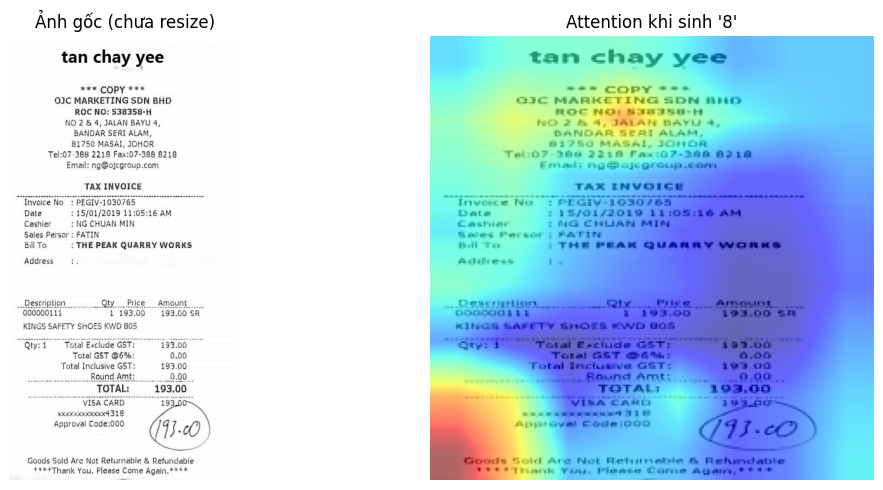

In [69]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load và xử lý ảnh
# img_path = '/content/SROIE2019/test_images/X51005301666.jpg'
# img_path = '/content/SROIE2019/test_images/X51005288570.jpg'
img_path = '/content/SROIE2019/test_images/X00016469670.jpg'

img_raw = Image.open(img_path)
timg = transform(img_raw).unsqueeze(0).to(device)  # [1,3,32,128]

# Load mô hình
model.eval()
model.load_state_dict(torch.load("/content/best_model.pth"))

# Dự đoán
text, attn_maps = ocr_predict(timg, model, vocab, device)
print('Predicted Text:', text)

# Hiển thị attention map tại bước 39
step = 39
plot_single_attention(img_raw, timg.squeeze(0), attn_maps[step], text[step])


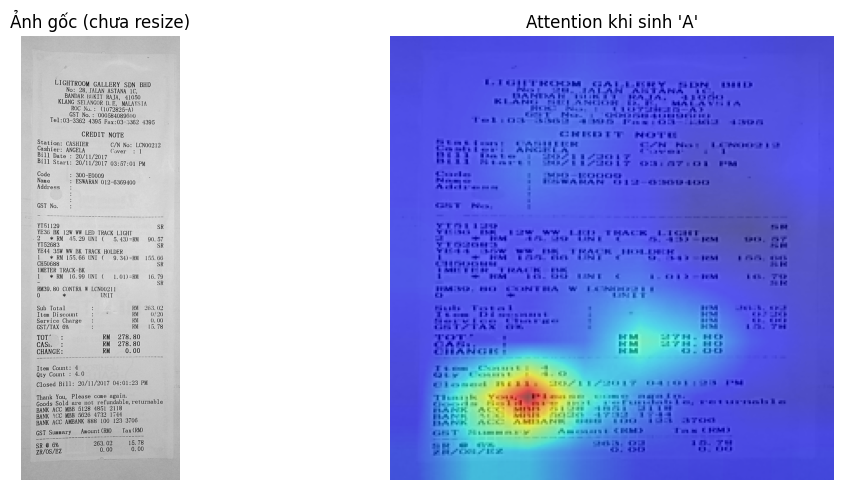

In [62]:
from PIL import Image

# ảnh gốc & tensor
# img_path = '/content/SROIE2019/test_images/X51005301666.jpg'
# img_raw = Image.open(img_path)
# img_tensor = transform(img_raw)    # [3,32,128]

# # predict
# batch = img_tensor.unsqueeze(0).to(device)
# # text, attn_maps = ocr_predict(batch, model, vocab, device)

# # plot
# step = 39
# plot_single_attention(img_raw, img_tensor, attn_maps[step], text[step])


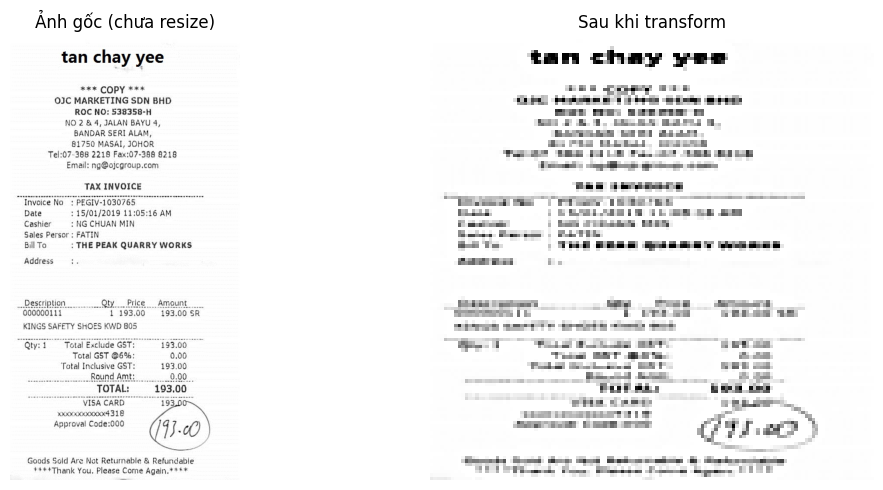

In [57]:
# import matplotlib.pyplot as plt
# import torch
# from PIL import Image
# import torchvision.transforms as transforms
# import numpy as np
# import torch.nn.functional as F

# from PIL import ImageFilter

# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Lambda(lambda img: img.filter(
#         ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3)
#     )),  # sharpen trực tiếp trên PIL Image
#     transforms.ToTensor(),
# ])









# img_path = '/content/SROIE2019/test_images/X00016469670.jpg'
# img_raw = Image.open(img_path)
# img = transform(img_raw)  # [1, H, W]

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# # 1) Ảnh gốc
# ax1.imshow(img_raw, cmap='gray')
# ax1.set_title("Ảnh gốc (chưa resize)")
# ax1.axis('off')

# # 2) Ảnh sau transform (grayscale)
# img2d = img.squeeze(0).numpy()      # [H, W]
# ax2.imshow(img2d, cmap='gray')
# ax2.set_title("Sau khi transform")
# ax2.axis('off')

# plt.tight_layout()
# plt.show()
